<a href="https://colab.research.google.com/github/Jendma/Academic/blob/main/Web%20Mining/Topic_Detection_BERT_EFCM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#GET the data
#Mounting path dari Google Colab
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/My Drive/"

In [ ]:
## Memuat Data
import pandas as pd

dataset = pd.read_csv("/content/Capres2014-1.1.csv", usecols=["Isi_Tweet"])

In [ ]:
# EXPLORE the data
## Menampilkan lima data terakhir
dataset.tail()

,Isi_Tweet
1880,Jangan kabur dari tanggung jawab dengan kemasa...
1881,@echo_hadiwibowo mana berani pmrntah..m G da y...
1882,@IndonesiaCapres ANAK MEDAN DUKUNG CAPRES JK D...
1883,"RT @idoidonajib: Jelek! ""@fallenokta: Apa komp..."
1884,"Langsung deh ngadu ke capres Hatta Rajasa, bia..."


In [ ]:
# MODEL the data
## Pra Pengolahan - Cleaning
import numpy as np
import re

def clean_text(tweet):

    # Convert to lower case
    tweet = tweet.lower()
    # remove unicode characters
    tweet = tweet.encode('ascii', 'ignore').decode()
    # Clean www.* or https?://*
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet)
    # Clean @username
    tweet = re.sub('@[^\s]+','',tweet)
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    #trim
    tweet = tweet.strip('\'"')

    return tweet

dataset["Isi_Tweet"] = dataset['Isi_Tweet'].map(lambda x: clean_text(x))
dataset = dataset[dataset['Isi_Tweet'].apply(lambda x: len(x.split()) >=1)]

print(dataset.shape)

(1885, 1)


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
## Pra Pengolahan - Representasi Data
from transformers import AutoTokenizer, TFAutoModel

bert_tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
bert_model = TFAutoModel.from_pretrained("indobenchmark/indobert-base-p2", trainable=False)

def tokenisasi(teks):
    encode_dict = bert_tokenizer(teks,
                                   add_special_tokens = True,
                                   max_length = 128,
                                   padding = 'max_length',
                                   truncation = True,
                                   return_attention_mask = True,
                                   return_tensors = 'tf',)

    tokenID = encode_dict['input_ids']
    attention_mask = encode_dict['attention_mask']

    return tokenID, attention_mask
    return tokenID

def bert(data):
    emb = []
    for teks in data:
        #print(teks)
        token, mask = tokenisasi(str(teks))
        emb.append(bert_model([token, mask])[1].numpy().tolist()[0])

    return emb

### BERT Embedding
bert_emb = np.array(bert(dataset.to_numpy()))

print(bert_emb.shape)

Some layers from the model checkpoint at indobenchmark/indobert-base-p2 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-base-p2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


(1885, 768)


In [ ]:
bert_emb

array([[-0.82634854, -0.32899153,  0.99581361, ..., -0.39502379,
         0.15848938,  0.8715468 ],
       [-0.87633973, -0.49829659,  0.99321967, ..., -0.39376828,
         0.03745089,  0.73490286],
       [-0.8328259 , -0.73633105,  0.92967701, ..., -0.49356997,
        -0.01186881,  0.83200425],
       ...,
       [-0.94800985, -0.66903979,  0.8307988 , ..., -0.60348201,
        -0.09140661,  0.02682824],
       [-0.86195791, -0.55870402,  0.92031193, ..., -0.60505778,
         0.1332722 ,  0.60401791],
       [-0.94625646, -0.76034552,  0.74249959, ..., -0.28264636,
        -0.13251896, -0.02302862]])

In [ ]:
## Model EFCM - Reduksi Dimensi
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components = 5)
data = svd.fit_transform(bert_emb)

print(data.shape)

(1885, 5)


In [ ]:
## Model EFCM - Clustering
from sklearn.cluster import KMeans
import sys
#sys.path.insert(0, path + "FCMeans")
from fcmeans import fcmeans

m =1.1
n_topics = 3
initkm = KMeans(n_clusters=n_topics, n_init=1).fit(data)
cntr, u = fcmeans(data.T, n_topics, m, error=0.0001, maxiter=200, init=initkm.cluster_centers_.T)
cluster_membership = np.argmax(u, axis=0)

print(cluster_membership.shape)

(1885,)


In [ ]:
### Topic Interpretation
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

#### Class Based TFIDF (C-TFIDF) Functions
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def extract_top_words_per_topic(tf_idf, count, docs_per_topic, n = 10):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    top_words = []
    for i in range(len(labels)):
      top_words.append([words[j] for j in indices [i]][::-1])
    return top_words

#### Topic Representation
docs = pd.DataFrame(list(dataset["Isi_Tweet"]), columns=["Doc"])
docs['Topic'] = cluster_membership
docs['Doc_ID'] = range(len(docs))
docs_per_topic = docs.dropna(subset=['Doc']).groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs))
top_words = extract_top_words_per_topic(tf_idf, count, docs_per_topic, 10)
print(top_words)

[['menjadi', 'hatta', 'dan', 'sebagai', 'mantan', 'tidak', 'tokoh', 'jusuf', 'wakil', 'kalla'], ['rt', 'prabowo', 'jadi', 'capres', 'jokowi', 'presiden', 'dukung', 'cawapres', 'dahlan', 'arb'], ['jadi', 'jd', 'yg', 'rt', 'jokowi', 'presiden', 'capres', 'arb', 'mau', 'di']]


In [ ]:
### Topic Coherence
import gensim
from itertools import combinations
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Memuat Model Word2Vec
w2v_model = gensim.models.Word2Vec.load(path + "idwiki-berita/w2v-model.bin")

### Fungsi Menghitung Coherence
def calculate_coherence( w2v_model, term_rankings):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations(term_rankings[topic_index], 2 ):
            if pair[0] in w2v_model.wv.index_to_key:
                if pair[1] in w2v_model.wv.index_to_key:
                    pair_scores.append( abs(w2v_model.wv.similarity(pair[0], pair[1])) )
                #else:
                    #pair_scores.append(0)
            #else:
                #pair_scores.append(0)

        # get the mean for all pairs in this topic
        if pair_scores:
            topic_score = sum(pair_scores) / len(pair_scores)
            overall_coherence += topic_score

    # get the mean score across all topics
    return overall_coherence / len(term_rankings)


### Menentukan Nilai Coherence dari Topik
calculate_coherence(w2v_model, top_words)

0.27501854046233115

The number of topics is 5
The simulation 1
Coherence value :  0.2621687633118459
The simulation 2
Coherence value :  0.2621687633118459
The number of topics is 6
The simulation 1
Coherence value :  0.25215155082661167
The simulation 2
Coherence value :  0.25215155082661167
The number of topics is 7
The simulation 1
Coherence value :  0.253514235774203
The simulation 2
Coherence value :  0.25365998230435277
The number of topics is 8
The simulation 1
Coherence value :  0.2523829197304116
The simulation 2
Coherence value :  0.2523829197304116
The number of topics is 9
The simulation 1
Coherence value :  0.25011096687287726
The simulation 2
Coherence value :  0.24237064818639764
The number of topics is 10
The simulation 1
Coherence value :  0.23704247550743202
The simulation 2
Coherence value :  0.24237391818403484
The number of topics is 11
The simulation 1
Coherence value :  0.24533612518309258
The simulation 2
Coherence value :  0.24451355091517882
The number of topics is 12
The simulat

Text(0, 0.5, 'Coherence')

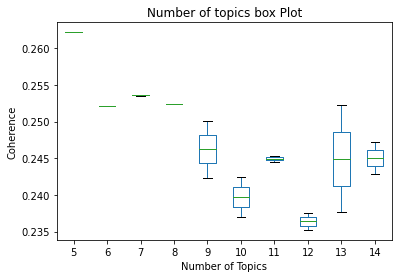

In [ ]:
## Parameter Tuning
### Jumlah Topik Optimal
import pandas as pd

num_topics = []
coherences = []
for n_topics in range(5,15,1):
    print("The number of topics is " + str(n_topics))

    coherence_sim = []
    for i in range(1,3):
        print("The simulation " + str(i))

        #topic detection
        m = 1.1
        initkm = KMeans(n_clusters=n_topics, n_init=1).fit(data)
        cntr, u = fcmeans(data.T, n_topics, m, error=0.0001, maxiter=200, init=initkm.cluster_centers_.T)
        cluster_membership = np.argmax(u, axis=0)

        docs = pd.DataFrame(list(dataset["Isi_Tweet"]), columns=["Doc"])
        docs['Topic'] = cluster_membership
        docs['Doc_ID'] = range(len(docs))
        docs_per_topic = docs.dropna(subset=['Doc']).groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

        tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs))
        top_words = extract_top_words_per_topic(tf_idf, count, docs_per_topic, 10)

        coherence_sim.append(calculate_coherence(w2v_model, top_words))
        print('Coherence value : ',coherence_sim[i-1])

    num_topics.append(n_topics)
    coherences.append(coherence_sim)

    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs))
    top_words = extract_top_words_per_topic(tf_idf, count, docs_per_topic, 10)

### Visualisasi
df = pd.DataFrame.from_records(coherences).T
df.columns = num_topics
boxplot = df.boxplot(grid=False)
boxplot.set_title('Number of topics box Plot')
boxplot.set_xlabel("Number of Topics")
boxplot.set_ylabel("Coherence")


In [ ]:
## yang terbaik adalah 11 topik
df = pd.DataFrame.from_records(coherences).T
df.columns = num_topics
df.mean().sort_values()


12    0.236411
10    0.239708
13    0.244914
11    0.244925
14    0.245031
9     0.246241
6     0.252152
8     0.252383
7     0.253587
5     0.262169
dtype: float64

In [ ]:
## Parameter Tuning
### Jumlah dimensi reduksi optimal
import pandas as pd

n_dim = []
coherences = []
n_topics = 15
for dim in range(5,16):
    print("The number of reducted dimension is " + str(dim))

    coherence_sim = []
    for i in range(1,3):
        print("The simulation " + str(i))

        #topic detection
        m = 1.1
        svd = TruncatedSVD(n_components = dim)
        data = svd.fit_transform(bert_emb)

        initkm = KMeans(n_clusters=n_topics, n_init=5).fit(data)
        cntr, u = fcmeans(data.T, n_topics, m, error=0.0001, maxiter=200, init=initkm.cluster_centers_.T)
        cluster_membership = np.argmax(u, axis=0)

        docs = pd.DataFrame(list(dataset["Isi_Tweet"]), columns=["Doc"])
        docs['Topic'] = cluster_membership
        docs['Doc_ID'] = range(len(docs))
        docs_per_topic = docs.dropna(subset=['Doc']).groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

        tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs))
        top_words = extract_top_words_per_topic(tf_idf, count, docs_per_topic, 10)

        coherence_sim.append(calculate_coherence(w2v_model, top_words))
        print('Coherence value : ',coherence_sim[i-1])

    n_dim.append(dim)
    coherences.append(coherence_sim)

The number of reducted dimension is 5
The simulation 1
Coherence value :  0.24637993773834765
The simulation 2
Coherence value :  0.24637993773834765
The number of reducted dimension is 6
The simulation 1
Coherence value :  0.2420836518971969
The simulation 2
Coherence value :  0.22735991485517906
The number of reducted dimension is 7
The simulation 1
Coherence value :  0.23547535039652037
The simulation 2
Coherence value :  0.22702229631899626
The number of reducted dimension is 8
The simulation 1
Coherence value :  0.237465569190681
The simulation 2
Coherence value :  0.23746556919068096
The number of reducted dimension is 9
The simulation 1
Coherence value :  0.2289236763945569
The simulation 2
Coherence value :  0.22892367639455688
The number of reducted dimension is 10
The simulation 1
Coherence value :  0.23824975755923086
The simulation 2
Coherence value :  0.2289236763945569
The number of reducted dimension is 11
The simulation 1
Coherence value :  0.2374810653783026
The simula

In [ ]:
df = pd.DataFrame.from_records(coherences).T
df.columns = n_dim
df.mean().sort_values()

9     0.228924
7     0.231249
10    0.233587
6     0.234722
13    0.235141
15    0.236404
8     0.237466
11    0.237481
14    0.237567
12    0.239880
5     0.246380
dtype: float64

Text(0.5, 1.0, 'Number of dim Line Plot')

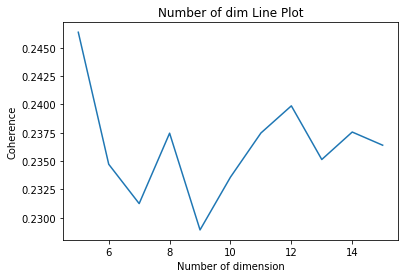

In [ ]:
import matplotlib.pyplot as plt
lineplot = df.mean(axis=0).plot(grid=False)
lineplot.set_xlabel("Number of dimension")
lineplot.set_ylabel("Coherence")
lineplot.set_title('Number of dim Line Plot')

In [ ]:
## Parameter Tuning
### Jumlah konstanta fcmeans
import pandas as pd

m_list = []
coherences = []
n_topics = 12
dim = 9
for m_i in [round(i*.1, 1) for i in range(11, 26)]:
    print("The number of m is " + str(m_i))

    coherence_sim = []
    for i in range(1,3):
        print("The simulation " + str(i))

        #topic detection
        m = m_i
        svd = TruncatedSVD(n_components = dim)
        data = svd.fit_transform(bert_emb)

        initkm = KMeans(n_clusters=n_topics, n_init=5).fit(data)
        cntr, u = fcmeans(data.T, n_topics, m, error=0.0001, maxiter=200, init=initkm.cluster_centers_.T)
        cluster_membership = np.argmax(u, axis=0)

        docs = pd.DataFrame(list(dataset["Isi_Tweet"]), columns=["Doc"])
        docs['Topic'] = cluster_membership
        docs['Doc_ID'] = range(len(docs))
        docs_per_topic = docs.dropna(subset=['Doc']).groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

        tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs))
        top_words = extract_top_words_per_topic(tf_idf, count, docs_per_topic, 10)

        coherence_sim.append(calculate_coherence(w2v_model, top_words))
        print('Coherence value : ',coherence_sim[i-1])

    m_list.append(m_i)
    coherences.append(coherence_sim)

The number of m is 1.1
The simulation 1
Coherence value :  0.2289236763945569
The simulation 2
Coherence value :  0.23334193326004352
The number of m is 1.2
The simulation 1
Coherence value :  0.2321059954766598
The simulation 2
Coherence value :  0.23983575514857727
The number of m is 1.3
The simulation 1
Coherence value :  0.2382243279946682
The simulation 2
Coherence value :  0.23822432799466822
The number of m is 1.4
The simulation 1
Coherence value :  0.2402300006402016
The simulation 2
Coherence value :  0.24023000064020159
The number of m is 1.5
The simulation 1
Coherence value :  0.23913657624501164
The simulation 2
Coherence value :  0.23783544578993565
The number of m is 1.6
The simulation 1
Coherence value :  0.23445335096388897
The simulation 2
Coherence value :  0.23207848826916055
The number of m is 1.7
The simulation 1
Coherence value :  0.23623966554662698
The simulation 2
Coherence value :  0.23623966554662698
The number of m is 1.8
The simulation 1
Coherence value :  

In [ ]:
df = pd.DataFrame.from_records(coherences).T
df.columns = m_list
df.mean().sort_values()

1.8    0.226035
1.9    0.226036
1.1    0.231133
2.0    0.231245
2.1    0.231253
2.3    0.231409
1.6    0.233266
1.2    0.235971
1.7    0.236240
2.4    0.237427
1.3    0.238224
1.5    0.238486
2.2    0.239569
1.4    0.240230
2.5    0.243713
dtype: float64

Text(0.5, 1.0, 'Number of m Line Plot')

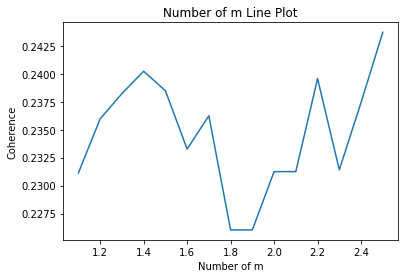

In [ ]:
import matplotlib.pyplot as plt
lineplot = df.mean(axis=0).plot(grid=False)
lineplot.set_xlabel("Number of m")
lineplot.set_ylabel("Coherence")
lineplot.set_title('Number of m Line Plot')

In [ ]:
## Model Test
import pandas as pd

num_topics = 12
dim = 9
m = 1.8
coherences = []
coherence_sim = []
topic_sim = []
for i in range(10):
  svd = TruncatedSVD(n_components = dim)
  data = svd.fit_transform(bert_emb)
  print("The simulation " + str(i+1))

  #topic detection
  m = 1.1
  initkm = KMeans(n_clusters=n_topics, n_init=1).fit(data)
  cntr, u = fcmeans(data.T, n_topics, m, error=0.0001, maxiter=200, init=initkm.cluster_centers_.T)
  cluster_membership = np.argmax(u, axis=0)

  docs = pd.DataFrame(list(dataset["Isi_Tweet"]), columns=["Doc"])
  docs['Topic'] = cluster_membership
  docs['Doc_ID'] = range(len(docs))
  docs_per_topic = docs.dropna(subset=['Doc']).groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

  tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs))
  top_words = extract_top_words_per_topic(tf_idf, count, docs_per_topic, 10)

  coherence_sim.append(calculate_coherence(w2v_model, top_words))
  print('Coherence value : ',coherence_sim[i])
  topic_sim.append(top_words)
coherences.append(coherence_sim)

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs))
top_words = extract_top_words_per_topic(tf_idf, count, docs_per_topic, 10)

### Visualisasi
df = pd.DataFrame.from_records(coherences).T

The simulation 1
Coherence value :  0.2386417168399526
The simulation 2
Coherence value :  0.22892367639455688
The simulation 3
Coherence value :  0.23334193326004357
The simulation 4
Coherence value :  0.2386417168399526
The simulation 5
Coherence value :  0.22892367639455694
The simulation 6
Coherence value :  0.23864171683995258
The simulation 7
Coherence value :  0.2401239398132675
The simulation 8
Coherence value :  0.2386417168399526
The simulation 9
Coherence value :  0.23739848506030817
The simulation 10
Coherence value :  0.22892367639455688


In [ ]:
for topic in topic_sim[9]:
  print(topic)

['jadi', 'rt', 'prabowo', 'presiden', 'jokowi', 'koruptor', 'capres', 'arb', 'dahlan', 'wakil']
['hatta', 'menjadi', 'evaluasi', 'radjasa', 'pencapresan', 'membuka', 'umumnya', 'kemungkinan', '2013pan', 'ketua']
['jadi', 'yg', 'kalo', 'mau', 'jd', 'ya', 'sama', 'aja', 'arb', 'jakarta']
['prabowo', 'adalah', 'presiden', 'harus', '2014', 'oleh', 'pilih', 'saya', 'dahlan', 'dan']
['jd', 'rt', 'jokowi', 'presiden', 'jadi', 'ya', 'aja', 'emoh', 'capres', 'ahok']
['acak', 'rt', 'jadi', 'guruh', 'apa', 'dukung', 'kalo', 'presd', 'acakan', 'metode']
['rt', 'capres', 'deklarasi', 'jk', 'jd', 'tdk', 'hanura', 'followradiopepatah', 'wiranto', 'yg']
['yg', 'dan', 'saya', 'ada', 'akan', 'prabowo', 'jk', 'jadi', 'no', 'capres']
['09', '42', '21', 'perbincangan', 'dinyatakan', 'terpopuler', '2013', '24', 'sosok', 'dalam']
['rt', 'cawapres', 'bung', 'bungkus', 'gimana', 'underdog', 'prabowo', 'politika', 'charta', 'mampu']
['wonogiri', 'vihara', 'forum', 'capres', 'petani', 'islam', 'jokowi', 'ppp', '